In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
data = pd.read_csv("VCB_Historical_Data.csv")
data

,Date,Close,Open,High,Low,Vol.,Change %
0,03-01-17,27643,26418,27828,26418,2580000,5.08%
1,04-01-17,27457,27828,27903,27309,1710000,-0.67%
2,05-01-17,27569,27383,27680,27346,1090000,0.41%
3,06-01-17,28125,27606,28496,27531,3180000,2.02%
4,09-01-17,28719,28348,28904,28274,3040000,2.11%
...,...,...,...,...,...,...,...
1736,14-12-23,84400,84000,84500,84000,840600,0.84%
1737,15-12-23,82200,84000,84400,82200,2530000,-2.61%
1738,18-12-23,81500,82800,82900,81500,1800000,-0.85%
1739,19-12-23,81200,81500,81500,80100,1960000,-0.37%


In [3]:
# 2. Gắn index với giá Close
data1 = data.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
data1=scaler.fit_transform(np.array(data1).reshape(-1,1))

In [5]:
# 4. Chia train test theo tỉ lệ 7:2:1
train_size = int(0.7 * len(data1))
test_size = int(0.2 * len(data1))
val_size = len(data1) - train_size - test_size

train_data = data1[:train_size]
test_data = data1[train_size:train_size+test_size]
val_data = data1[train_size+test_size:]

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [9]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [10]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100

18/18 [==============================] - 19s 344ms/step - loss: 0.0398 - val_loss: 0.0321
Epoch 2/100
18/18 [==============================] - 3s 160ms/step - loss: 0.0047 - val_loss: 0.0089
Epoch 3/100
18/18 [==============================] - 3s 158ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 4/100
18/18 [==============================] - 4s 220ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 5/100
18/18 [==============================] - 3s 159ms/step - loss: 0.0015 - val_loss: 0.0029
Epoch 6/100
18/18 [==============================] - 3s 159ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 7/100
18/18 [==============================] - 3s 168ms/step - loss: 0.0014 - val_loss: 0.0025
Epoch 8/100
18/18 [==============================] - 5s 265ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 9/100
18/18 [==============================] - 5s 303ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/100
18/18 [==============================] - 6s 305ms/step - loss: 0.0012 - val_

In [11]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 45ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 86678.6513653828
Testing RMSE: 80626.3209398571


In [14]:
# Đánh giá độ chính xác thuật toán bằng MAE
valid_mae = np.mean(np.abs(y_pred_val - yval))
test_mae = np.mean(np.abs(y_pred - ytest))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 86661.8718590493
Testing MAE: 80318.30331565916


In [15]:
# Đánh giá độ chính xác thuật toán bằng MAPE
valid_mape = np.mean(np.abs((y_pred_val - yval) / yval)) * 100
test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 11547421.05267887
Testing MAPE: 12121772.149096359


In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=114
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.96899725 0.98015824 0.98139835 0.97891813 0.97271758 1.
 0.98139835 0.98139835 0.77763585 0.8164637  0.83754557 0.8288648
 0.83258513 0.81522359 0.81026315 0.81398348 0.80282249 0.79662194
 0.80530271 0.8040626  0.79786205 0.77678018 0.80034227 0.78298073
 0.78174062 0.78546095 0.78794117 0.78918128 0.79290161 0.77554007
 0.74949776 0.75817853 0.74825765 0.75817853 0.77554007 0.78422084
 0.78422084 0.79662194 0.79786205 0.78918128 0.78918128 0.77678018
 0.79414172 0.78422084 0.78422084 0.79290161 0.78050051 0.77181974
 0.77057963 0.75817853 0.78670106 0.78670106 0.75817853 0.76809941
 0.77057963 0.76437908 0.75197798 0.74949776 0.74949776 0.72717577
 0.73833676 0.72841588 0.74701754 0.75197798 0.74577743 0.75321809
 0.74701754 0.74453731 0.74453731 0.72717577 0.7308961  0.72717577
 0.74577743 0.7432972  0.72717577 0.73337632 0.74453731 0.75569831
 0.76809941 0.78298073 0.78174062 0.78918128 0.77429996 0.78918128
 0.76933952 0.74577743 0.73957687 0.74577743 0.7668593  0.7

In [17]:
# 14. Kết quả dự báo 30 ngày tiếp theo
y_future = scaler.inverse_transform(lst_output)
y_future

array([[81299.73100972],
       [81420.82343483],
       [81541.58902478],
       [81654.89988935],
       [81835.55321515],
       [82074.68600178],
       [82326.32984591],
       [82571.42256773],
       [82811.6800518 ],
       [83045.29028559],
       [83264.65435171],
       [83464.4515661 ],
       [83643.44668412],
       [83801.77909136],
       [83939.41033661],
       [84056.67206144],
       [84154.60725451],
       [84234.80202758],
       [84298.90497565],
       [84348.65601528],
       [84385.83832061],
       [84412.32158101],
       [84429.86493862],
       [84440.17466521],
       [84444.87532377],
       [84445.48093009],
       [84443.29401839],
       [84439.5498333 ],
       [84435.28655708],
       [84431.35972881]])

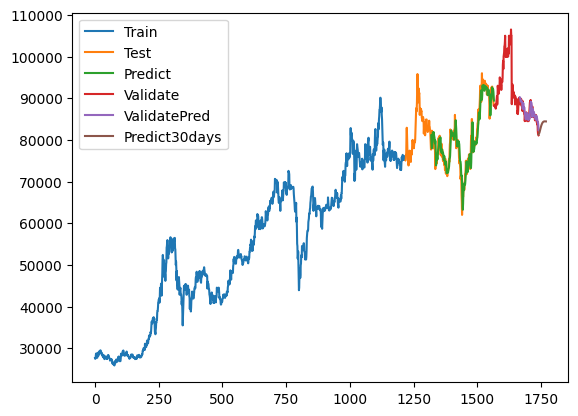

In [18]:
# 15.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(data1)-1, stop=len(data1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()